## just plotting by time (50Hz)

below coding is obsolete

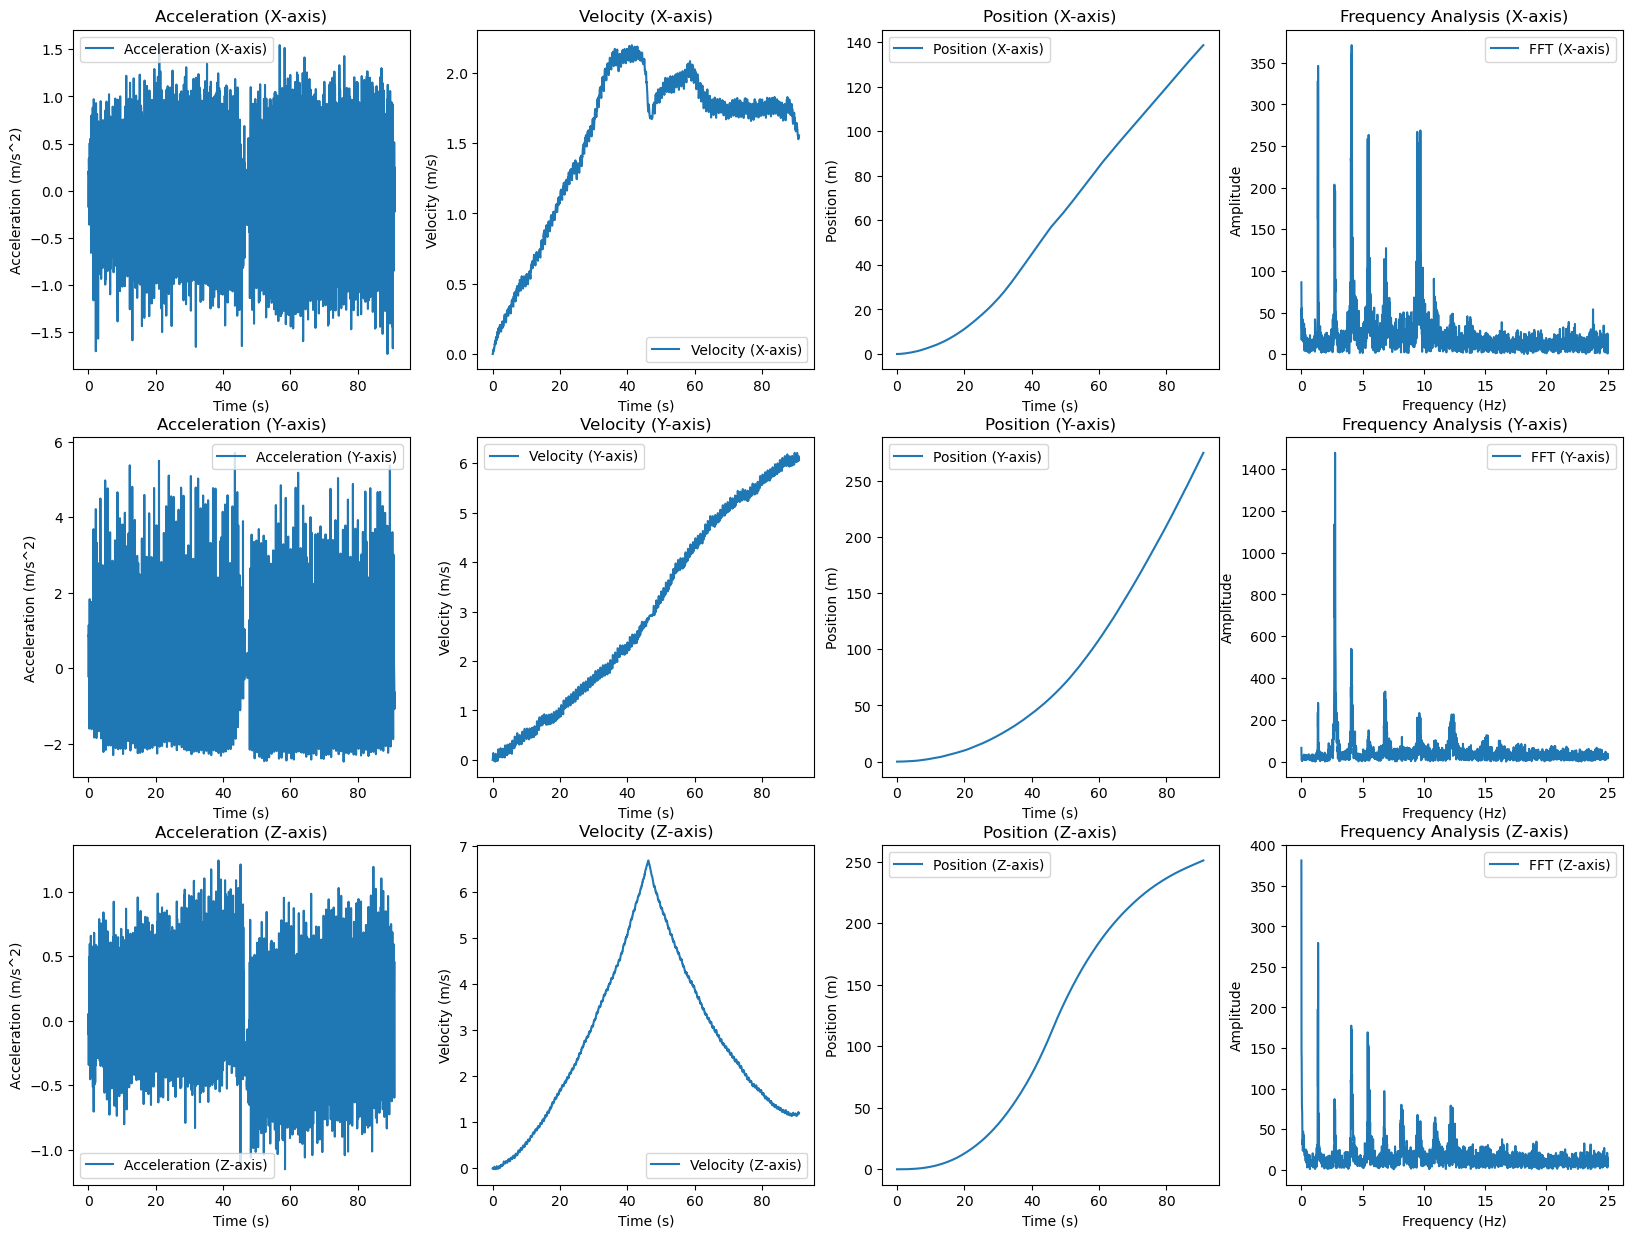

In [10]:

def plot_movement(file_path, sample_rate=50):
    df = pd.read_csv('./Motion/'+file_path)
    time = np.linspace(0, len(df)/sample_rate, len(df))

    fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows for x, y, z axes and 4 columns for the four graphs
    
    for i, axis in enumerate(['x', 'y', 'z']):
        acceleration = df[f'userAcceleration.{axis}']
        velocity = cumtrapz(acceleration, dx=1/sample_rate, initial=0)
        position = cumtrapz(velocity, dx=1/sample_rate, initial=0)
        sp = np.fft.fft(acceleration)
        freq = np.fft.fftfreq(len(sp), 1 / sample_rate)
        
        data = [acceleration, velocity, position, sp]  # List of data for the four graphs
        titles = ['Acceleration', 'Velocity', 'Position', 'Frequency Analysis']
        ylabels = ['Acceleration (m/s^2)', 'Velocity (m/s)', 'Position (m)', 'Amplitude']
        
        for j in range(4):
            ax = axs[i, j]
            if j < 3:  # For Acceleration, Velocity, and Position
                ax.plot(time, data[j], label=f'{titles[j]} ({axis.upper()}-axis)')
                ax.set_xlabel('Time (s)')
            else:  # For Frequency Analysis
                ax.plot(freq[freq > 0], np.abs(data[j][freq > 0]), label=f'FFT ({axis.upper()}-axis)')
                ax.set_xlabel('Frequency (Hz)')
            ax.set_title(f'{titles[j]} ({axis.upper()}-axis)')
            ax.set_ylabel(ylabels[j])
            ax.legend()
    
    #plt.tight_layout()
    plt.show()

# Run the function on the dataset
plot_movement('jog_9/sub_7.csv')

----Starts from here----

Total Acceleration=Gravity+User Acceleration

The dataset contains various columns, but we'll focus on Acceleration_x, Acceleration_y, and Acceleration_z for this analysis.

Next, let's proceed with the calculations:

Velocity: We'll integrate the acceleration data to obtain velocity. For the integration, we'll need to know the time interval between each data point. Could you please provide this information?

Position: After getting the velocity, we'll integrate again to obtain the position.

Energy: Kinetic energy is given by 
�
�
=
1
2
�
�
2
KE= 
2
1
​
 mv 
2
 , where 
�
m is mass and 
�
v is the velocity. If we assume a constant mass, we can compute the kinetic energy for each data point based on the calculated velocity.

Dominant Frequencies: We'll perform a Fast Fourier Transform (FFT) on the acceleration data to find the dominant frequencies.

Could you please provide the time interval between each data sample?

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.fftpack import fft


In [58]:
#nested for loop
for i, axis in enumerate(['x', 'y', 'z']):
    for j in range(4):
        print('Row '+str(i),'Axis '+axis,'Col(Acc, Vel, Pos, Freq) '+str(j))

Row 0 Axis x Col(Acc, Vel, Pos, Freq) 0
Row 0 Axis x Col(Acc, Vel, Pos, Freq) 1
Row 0 Axis x Col(Acc, Vel, Pos, Freq) 2
Row 0 Axis x Col(Acc, Vel, Pos, Freq) 3
Row 1 Axis y Col(Acc, Vel, Pos, Freq) 0
Row 1 Axis y Col(Acc, Vel, Pos, Freq) 1
Row 1 Axis y Col(Acc, Vel, Pos, Freq) 2
Row 1 Axis y Col(Acc, Vel, Pos, Freq) 3
Row 2 Axis z Col(Acc, Vel, Pos, Freq) 0
Row 2 Axis z Col(Acc, Vel, Pos, Freq) 1
Row 2 Axis z Col(Acc, Vel, Pos, Freq) 2
Row 2 Axis z Col(Acc, Vel, Pos, Freq) 3


## Seeing huge drifts how to correct this??
- Trick 1 : Sum Gravity + userAcceleration
- Trick 2 : Apply High pass filter

In [59]:
df = pd.read_csv('./Motion/dws_1/sub_1.csv')
df
file_path = 'jog_16/sub_7.csv'
df['label'] = file_path[:3]
df

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,label
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,jog
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,jog
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,jog
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,jog
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,jog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,1746,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874,jog
1747,1747,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738,jog
1748,1748,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740,jog
1749,1749,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441,jog


In [60]:
import numpy as np
from scipy.signal import butter, filtfilt

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y



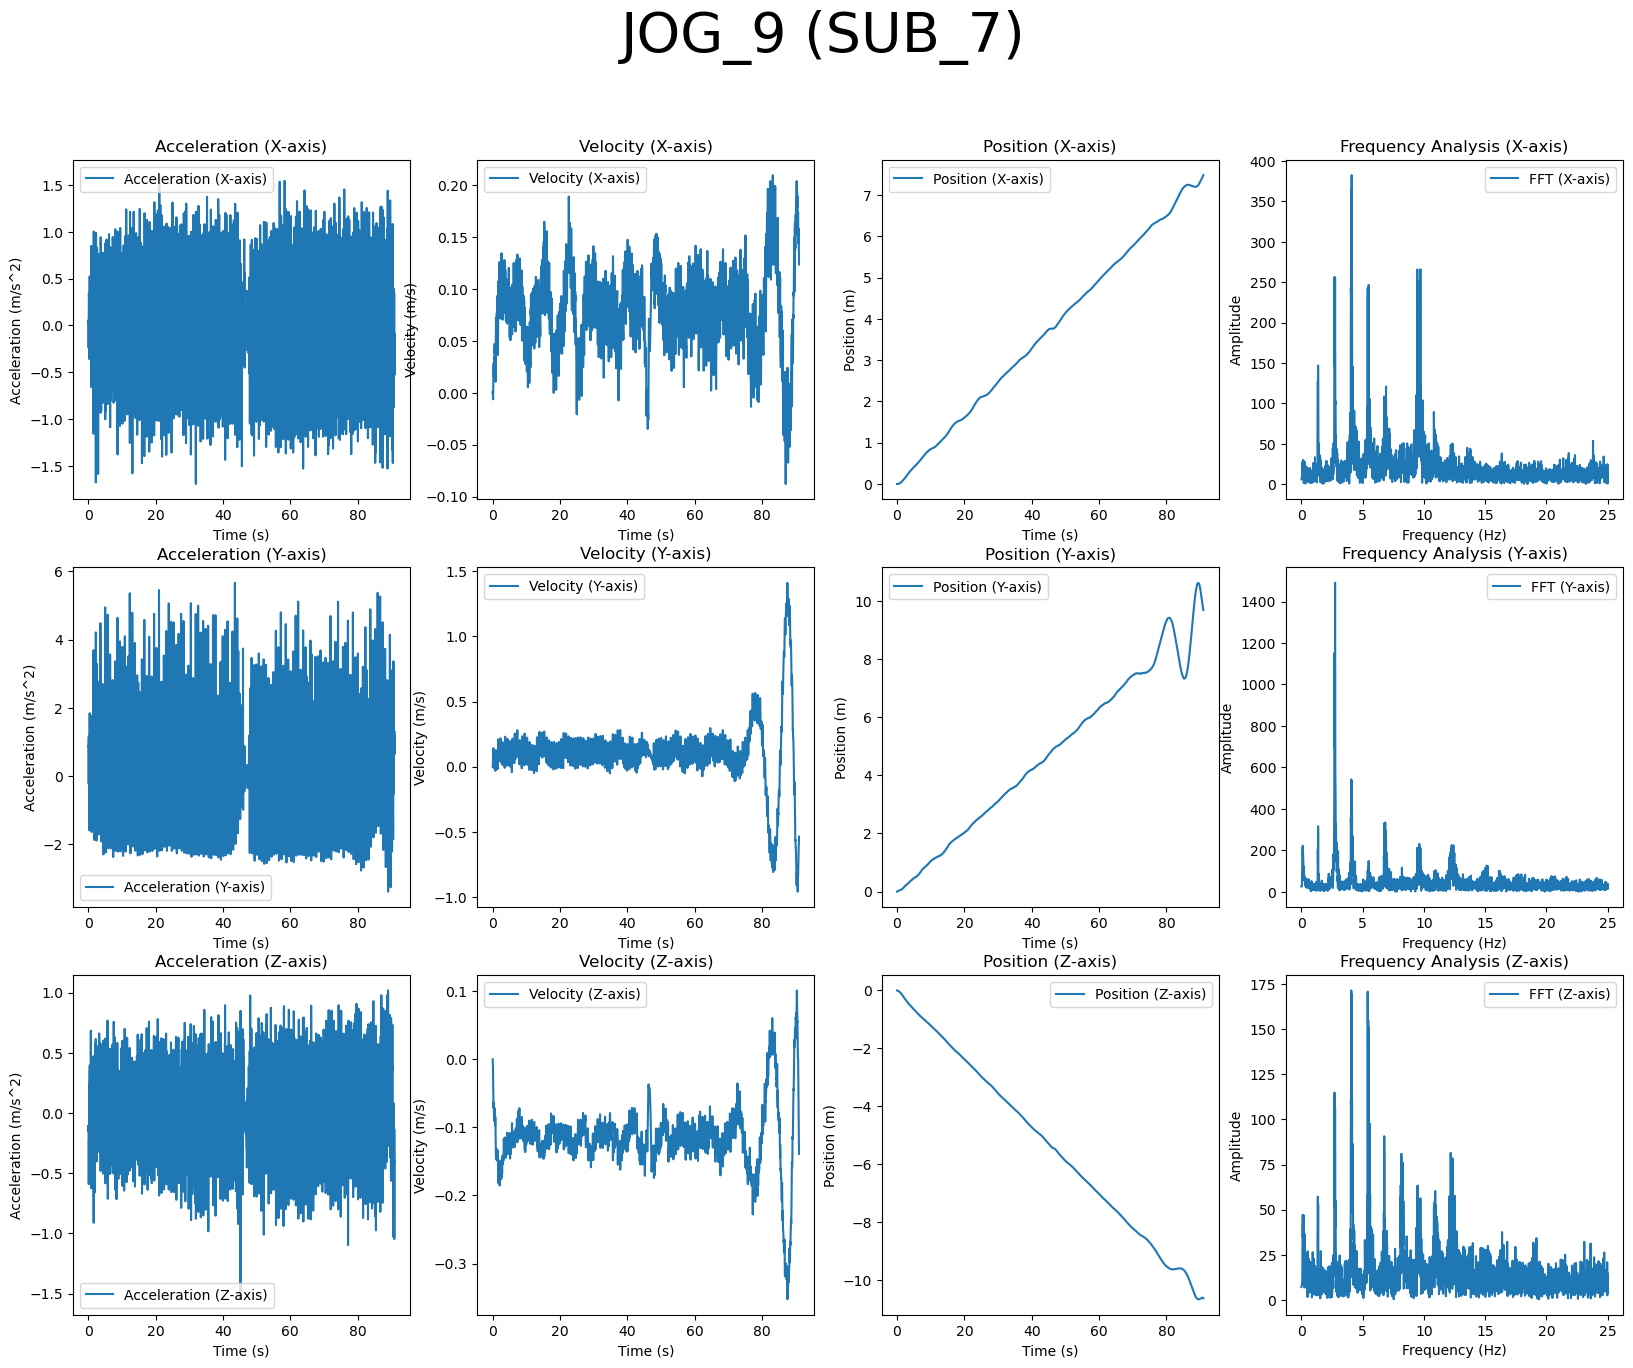

In [61]:

def plot_movement_grav(file_path, sample_rate=50):
    df = pd.read_csv('./Motion/'+file_path)
    df['label'] = file_path[:3]
    time = np.linspace(0, len(df)/sample_rate, len(df))

    fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows for x, y, z axes and 4 columns for the four graphs
    
    # title coming from the file_path format (jog_16/sub_7.csv)
    activity = file_path.split('/')[0].upper()
    person = file_path.split('/')[-1].upper()[:5]
    full_title = f"{activity} ({person})"
    fig.suptitle(full_title,fontsize=40)
    
    for i, axis in enumerate(['x', 'y', 'z']):
        df[f'Acceleration.{axis}'] = df[f'gravity.{axis}']+df[f'userAcceleration.{axis}']
        # acceleration = df[f'Acceleration.{axis}']
        acceleration = highpass_filter(df[f'Acceleration.{axis}'], cutoff=0.1, fs=50)
        velocity = cumtrapz(acceleration, dx=1/sample_rate, initial=0)
        position = cumtrapz(velocity, dx=1/sample_rate, initial=0)
        sp = np.fft.fft(acceleration)
        freq = np.fft.fftfreq(len(sp), 1 / sample_rate)
        
        data = [acceleration, velocity, position, sp]  # List of data for the four graphs
        titles = ['Acceleration', 'Velocity', 'Position', 'Frequency Analysis']
        ylabels = ['Acceleration (m/s^2)', 'Velocity (m/s)', 'Position (m)', 'Amplitude']
        
        for j in range(4):
            ax = axs[i, j]
            if j < 3:  # For Acceleration, Velocity, and Position
                ax.plot(time, data[j], label=f'{titles[j]} ({axis.upper()}-axis)')
                ax.set_xlabel('Time (s)')
            else:  # For Frequency Analysis
                ax.plot(freq[freq > 0], np.abs(data[j][freq > 0]), label=f'FFT ({axis.upper()}-axis)')
                ax.set_xlabel('Frequency (Hz)')
            ax.set_title(f'{titles[j]} ({axis.upper()}-axis)')
            ax.set_ylabel(ylabels[j])
            ax.legend()
    
    #plt.tight_layout()
    plt.show()

# Run the function on the dataset
plot_movement_grav('jog_9/sub_7.csv')

### I want to do frequency analysis, and adding annotation in my frequency plots

In [ ]:
...
else:  # For Frequency Analysis
    ax.plot(freq[freq > 0], np.abs(data[j][freq > 0]), label=f'FFT ({axis.upper()}-axis)')
    ax.set_xlabel('Frequency (Hz)')
    
    # Additional lines to annotate dominant frequency and amplitude
    pos_freq = freq[freq > 0]
    pos_sp = np.abs(sp[freq > 0])
    dominant_frequency = pos_freq[np.argmax(pos_sp)]
    amplitude_at_dominant_frequency = np.max(pos_sp)
    ax.annotate(f'Dominant Frequency: {dominant_frequency:.2f} Hz\nAmplitude: {amplitude_at_dominant_frequency:.2f}', 
                xy=(dominant_frequency, amplitude_at_dominant_frequency), 
                xytext=(dominant_frequency + 1, amplitude_at_dominant_frequency),
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=12,
                color='red')
...


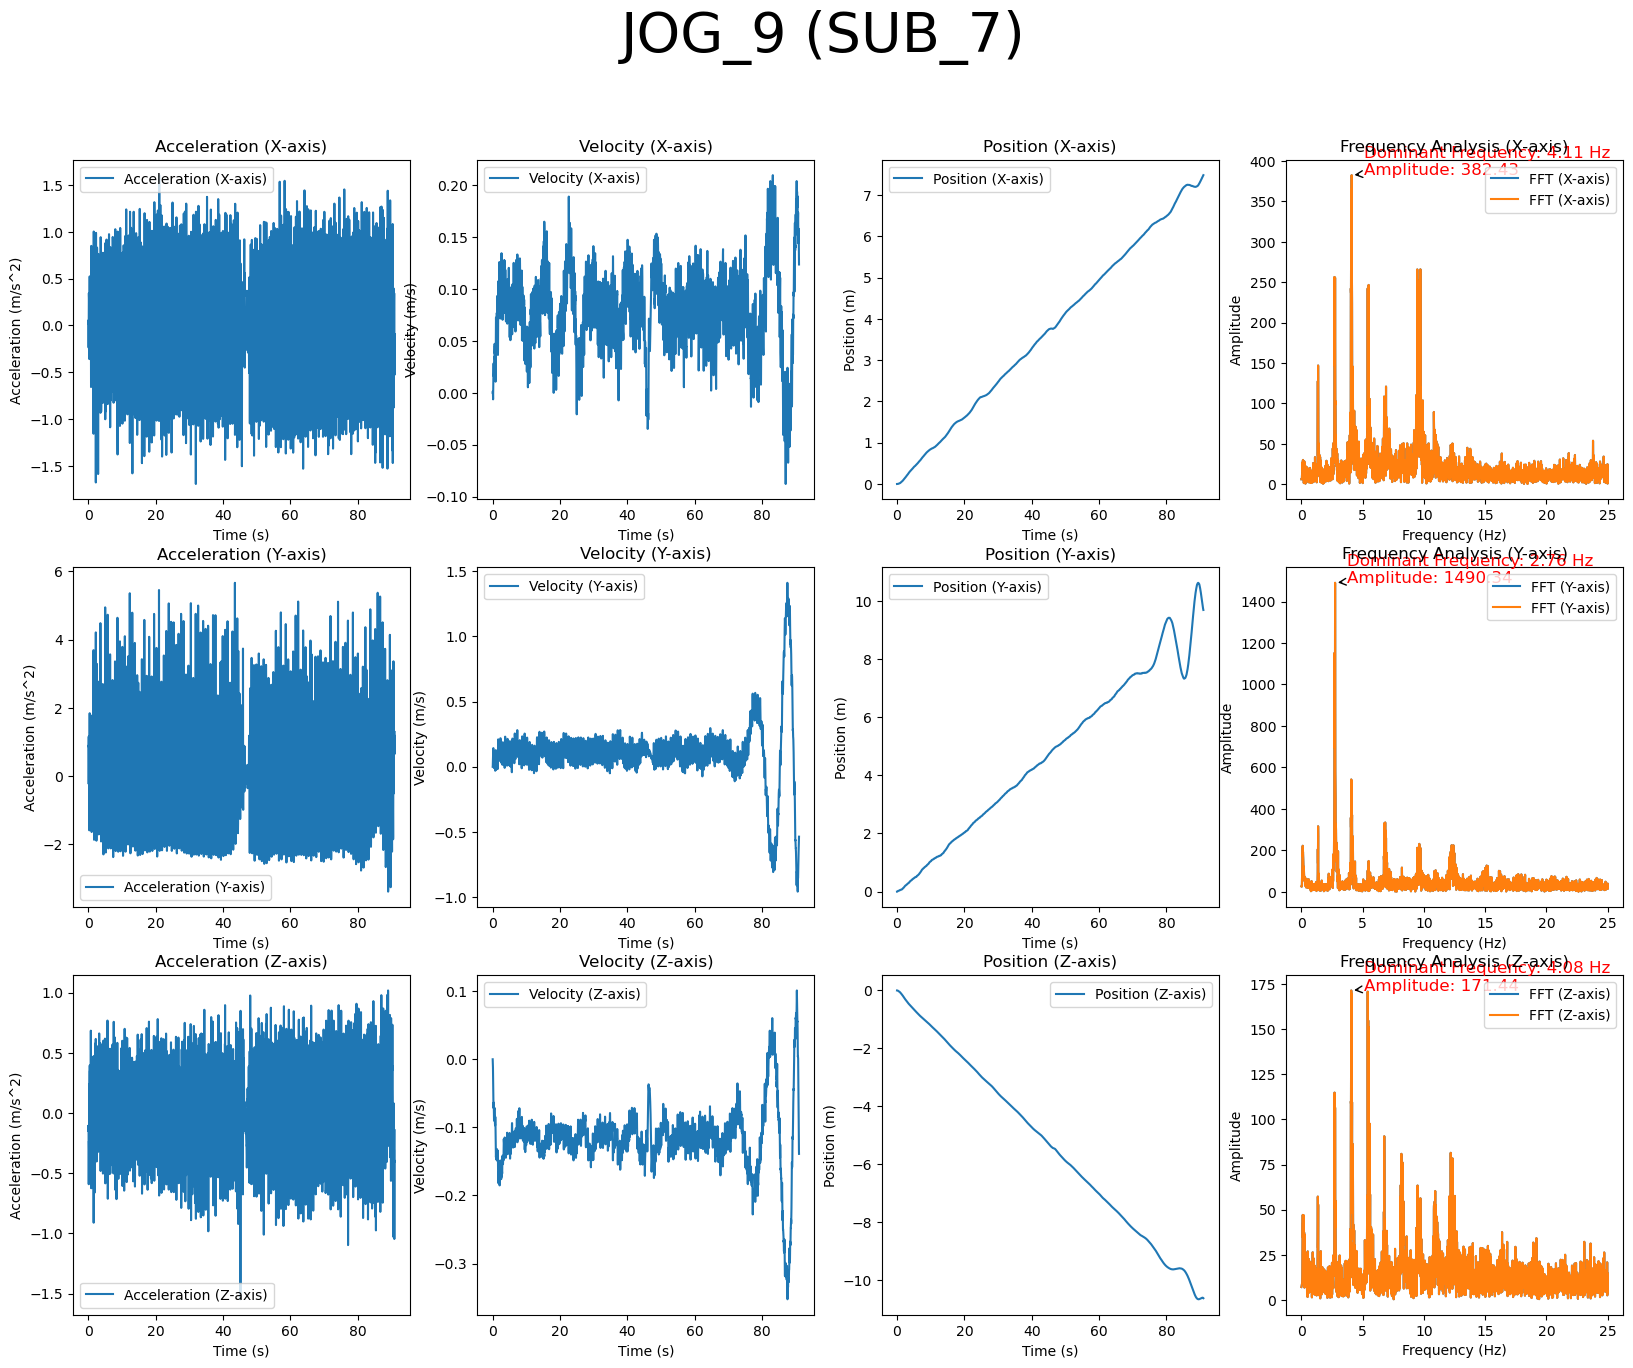

In [72]:

def plot_movement_grav_HF_anno(file_path, sample_rate=50):
    df = pd.read_csv('./Motion/'+file_path)
    df['label'] = file_path[:3]
    time = np.linspace(0, len(df)/sample_rate, len(df))

    fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows for x, y, z axes and 4 columns for the four graphs
    
    # title coming from the file_path format (jog_16/sub_7.csv)
    activity = file_path.split('/')[0].upper()
    person = file_path.split('/')[-1].upper()[:5]
    full_title = f"{activity} ({person})"
    fig.suptitle(full_title,fontsize=40)
    
    for i, axis in enumerate(['x', 'y', 'z']):
        df[f'Acceleration.{axis}'] = df[f'gravity.{axis}']+df[f'userAcceleration.{axis}']
        # acceleration = df[f'Acceleration.{axis}']
        acceleration = highpass_filter(df[f'Acceleration.{axis}'], cutoff=0.1, fs=50)
        velocity = cumtrapz(acceleration, dx=1/sample_rate, initial=0)
        position = cumtrapz(velocity, dx=1/sample_rate, initial=0)
        sp = np.fft.fft(acceleration)
        freq = np.fft.fftfreq(len(sp), 1 / sample_rate)
        
        data = [acceleration, velocity, position, sp]  # List of data for the four graphs
        titles = ['Acceleration', 'Velocity', 'Position', 'Frequency Analysis']
        ylabels = ['Acceleration (m/s^2)', 'Velocity (m/s)', 'Position (m)', 'Amplitude']
        
        for j in range(4):
            ax = axs[i, j]
            if j < 3:  # For Acceleration, Velocity, and Position
                ax.plot(time, data[j], label=f'{titles[j]} ({axis.upper()}-axis)')
                ax.set_xlabel('Time (s)')
                
            else:  # For Frequency Analysis
                ax.plot(freq[freq > 0], np.abs(data[j][freq > 0]), label=f'FFT ({axis.upper()}-axis)')
                ax.set_xlabel('Frequency (Hz)')

                # Additional lines to annotate dominant frequency and amplitude
                pos_freq = freq[freq > 0]
                pos_sp = np.abs(sp[freq > 0])
                
                dominant_frequency = pos_freq[np.argmax(pos_sp)]
                amplitude_at_dominant_frequency = np.max(pos_sp)
                
                ax.annotate(f'Dominant Frequency: {dominant_frequency:.2f} Hz\nAmplitude: {amplitude_at_dominant_frequency:.2f}', 
                xy=(dominant_frequency, amplitude_at_dominant_frequency), 
                xytext=(dominant_frequency + 1, amplitude_at_dominant_frequency),
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=12,
                color='red')
                ax.plot(freq[freq > 0], np.abs(data[j][freq > 0]), label=f'FFT ({axis.upper()}-axis)')
                ax.set_xlabel('Frequency (Hz)')
            ax.set_title(f'{titles[j]} ({axis.upper()}-axis)')
            ax.set_ylabel(ylabels[j])
            ax.legend()
    
    #plt.tight_layout()
    plt.show()

# Run the function on the dataset
plot_movement_grav_HF_anno('jog_9/sub_7.csv')

In [63]:
def extract_fft_features(file_path, sample_rate=50):
    df = pd.read_csv('./Motion/'+file_path)
    activity_label = file_path.split('/')[0]
    person_id = file_path.split('/')[-1].split('_')[1].split('.')[0]

    fft_features = {}
    fft_features['activity'] = activity_label
    fft_features['person_id'] = person_id

    for axis in ['x', 'y', 'z']:
        df[f'Acceleration.{axis}'] = df[f'gravity.{axis}'] + df[f'userAcceleration.{axis}']
        acceleration = highpass_filter(df[f'Acceleration.{axis}'], cutoff=0.1, fs=50)

        sp = np.fft.fft(acceleration)
        freq = np.fft.fftfreq(len(sp), 1 / sample_rate)

        # Assuming the FFT is symmetrical, only consider the positive part
        pos_freq = freq[freq > 0]
        pos_sp = np.abs(sp[freq > 0])

        # Get the dominant frequency and its amplitude
        dominant_frequency = pos_freq[np.argmax(pos_sp)]
        amplitude_at_dominant_frequency = np.max(pos_sp)

        fft_features[f'dominant_frequency_{axis}'] = dominant_frequency
        fft_features[f'amplitude_at_dominant_frequency_{axis}'] = amplitude_at_dominant_frequency

    return fft_features

# Example usage:
file_path = 'jog_9/sub_7.csv'
fft_features = extract_fft_features(file_path)
print(fft_features)


{'activity': 'jog_9', 'person_id': '7', 'dominant_frequency_x': 4.110793581006814, 'amplitude_at_dominant_frequency_x': 382.4340703243633, 'dominant_frequency_y': 2.758848098483183, 'amplitude_at_dominant_frequency_y': 1490.338180512165, 'dominant_frequency_z': 4.077819300945262, 'amplitude_at_dominant_frequency_z': 171.43914714458464}


In [64]:
sp

NameError: name 'sp' is not defined

### Now let's Train a machine learning model 
- ##### objective : to classify types of activity being performed.

- combine all data into 1 big dataframe
- add label to another column

In [62]:
# folders = ['dws_1','dws_2','dws_11','jog_9','jog_16','sit_5','sit_13','std_6','std_14','ups_3','ups_4','ups_12','wlk_7','wlk_8','wlk_15']
folders = ['dws_1','jog_9','sit_13','std_14','ups_3','wlk_7']
all_data = [] # This list will store all the data


# ex) df = pd.read_csv('./Motion/jog_9/sub_7.csv')

for folder in folders:
    for i in range(1,24):
        file_path = f'./Motion/{folder}/sub_{i}.csv'
        df = pd.read_csv(file_path)
        df['activity'] = folder[:3]
        all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

In [55]:
df_all

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,dws
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,dws
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,dws
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,dws
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,dws
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538886,6500,0.840159,-1.120595,-1.665542,0.324075,0.900359,-0.290393,-1.807416,2.179475,-0.183658,-0.423715,-0.180785,0.252399,wlk
538887,6501,0.926555,-1.142955,-1.618603,0.331742,0.909864,-0.249190,-1.272295,2.205748,-0.291049,-0.295380,-0.250898,0.230697,wlk
538888,6502,0.998220,-1.161482,-1.590613,0.334506,0.917394,-0.215626,-0.872821,2.344712,-0.490331,-0.264330,-0.242070,0.221714,wlk
538889,6503,1.061203,-1.179214,-1.572379,0.333160,0.924306,-0.186178,-0.715772,2.239321,-0.643991,-0.175339,-0.101049,0.247839,wlk


In [56]:
df

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity
0,0,0.207347,-1.135639,-1.353765,0.086783,0.906804,-0.412524,0.608106,-2.369625,0.719840,-0.079596,-0.520634,0.390993,wlk
1,1,0.177825,-1.124618,-1.334449,0.076332,0.902103,-0.424717,0.362281,-2.325881,0.383713,-0.093681,-0.556827,0.334247,wlk
2,2,0.141098,-1.120729,-1.325719,0.061178,0.900418,-0.430703,0.035447,-2.167201,0.146218,-0.132940,-0.578839,0.279961,wlk
3,3,0.104723,-1.123689,-1.321118,0.045195,0.901702,-0.429990,-0.277767,-1.927094,0.046514,-0.140426,-0.551390,0.261411,wlk
4,4,0.072529,-1.133891,-1.318571,0.030663,0.906065,-0.422025,-0.658007,-1.592157,-0.000368,-0.138939,-0.447676,0.110578,wlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6500,6500,0.840159,-1.120595,-1.665542,0.324075,0.900359,-0.290393,-1.807416,2.179475,-0.183658,-0.423715,-0.180785,0.252399,wlk
6501,6501,0.926555,-1.142955,-1.618603,0.331742,0.909864,-0.249190,-1.272295,2.205748,-0.291049,-0.295380,-0.250898,0.230697,wlk
6502,6502,0.998220,-1.161482,-1.590613,0.334506,0.917394,-0.215626,-0.872821,2.344712,-0.490331,-0.264330,-0.242070,0.221714,wlk
6503,6503,1.061203,-1.179214,-1.572379,0.333160,0.924306,-0.186178,-0.715772,2.239321,-0.643991,-0.175339,-0.101049,0.247839,wlk


## Experiment 
### To compare

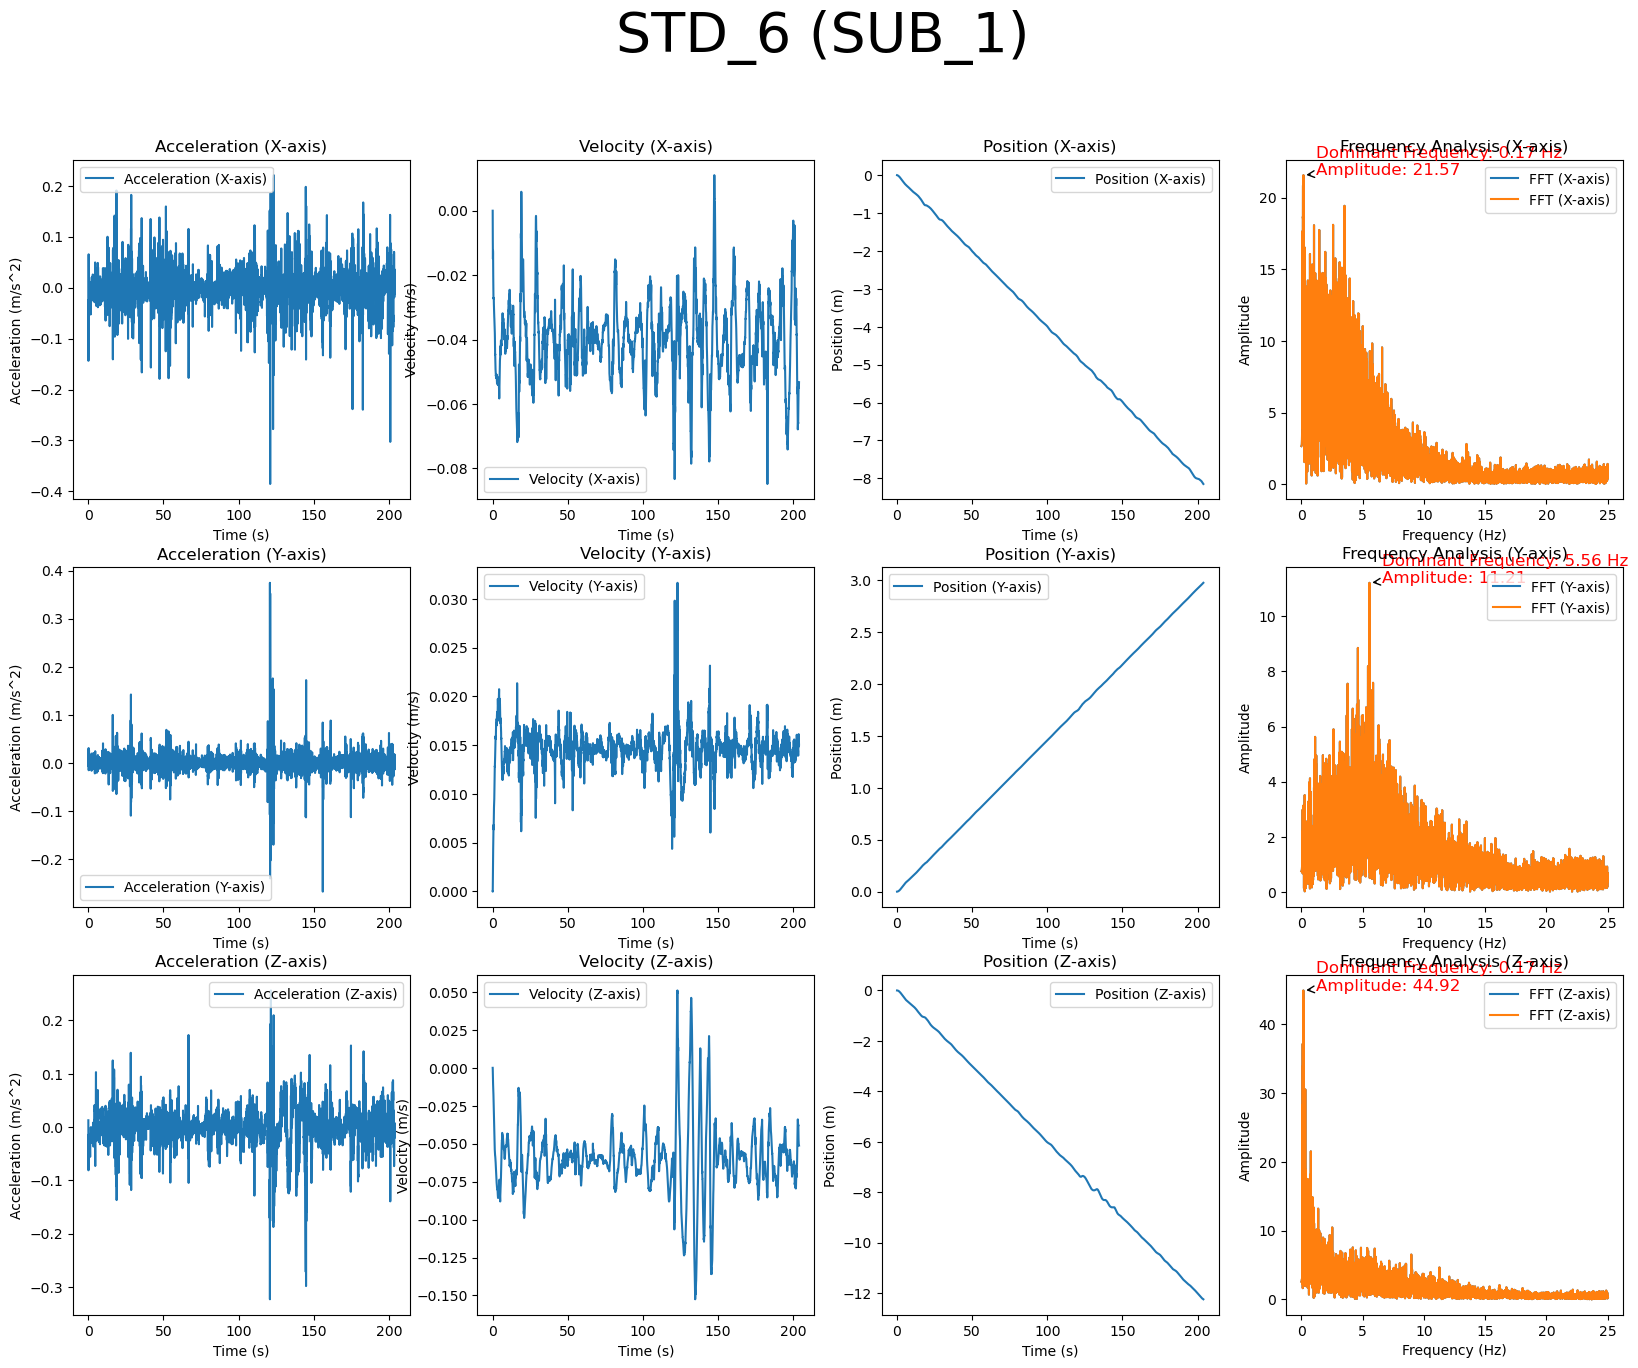

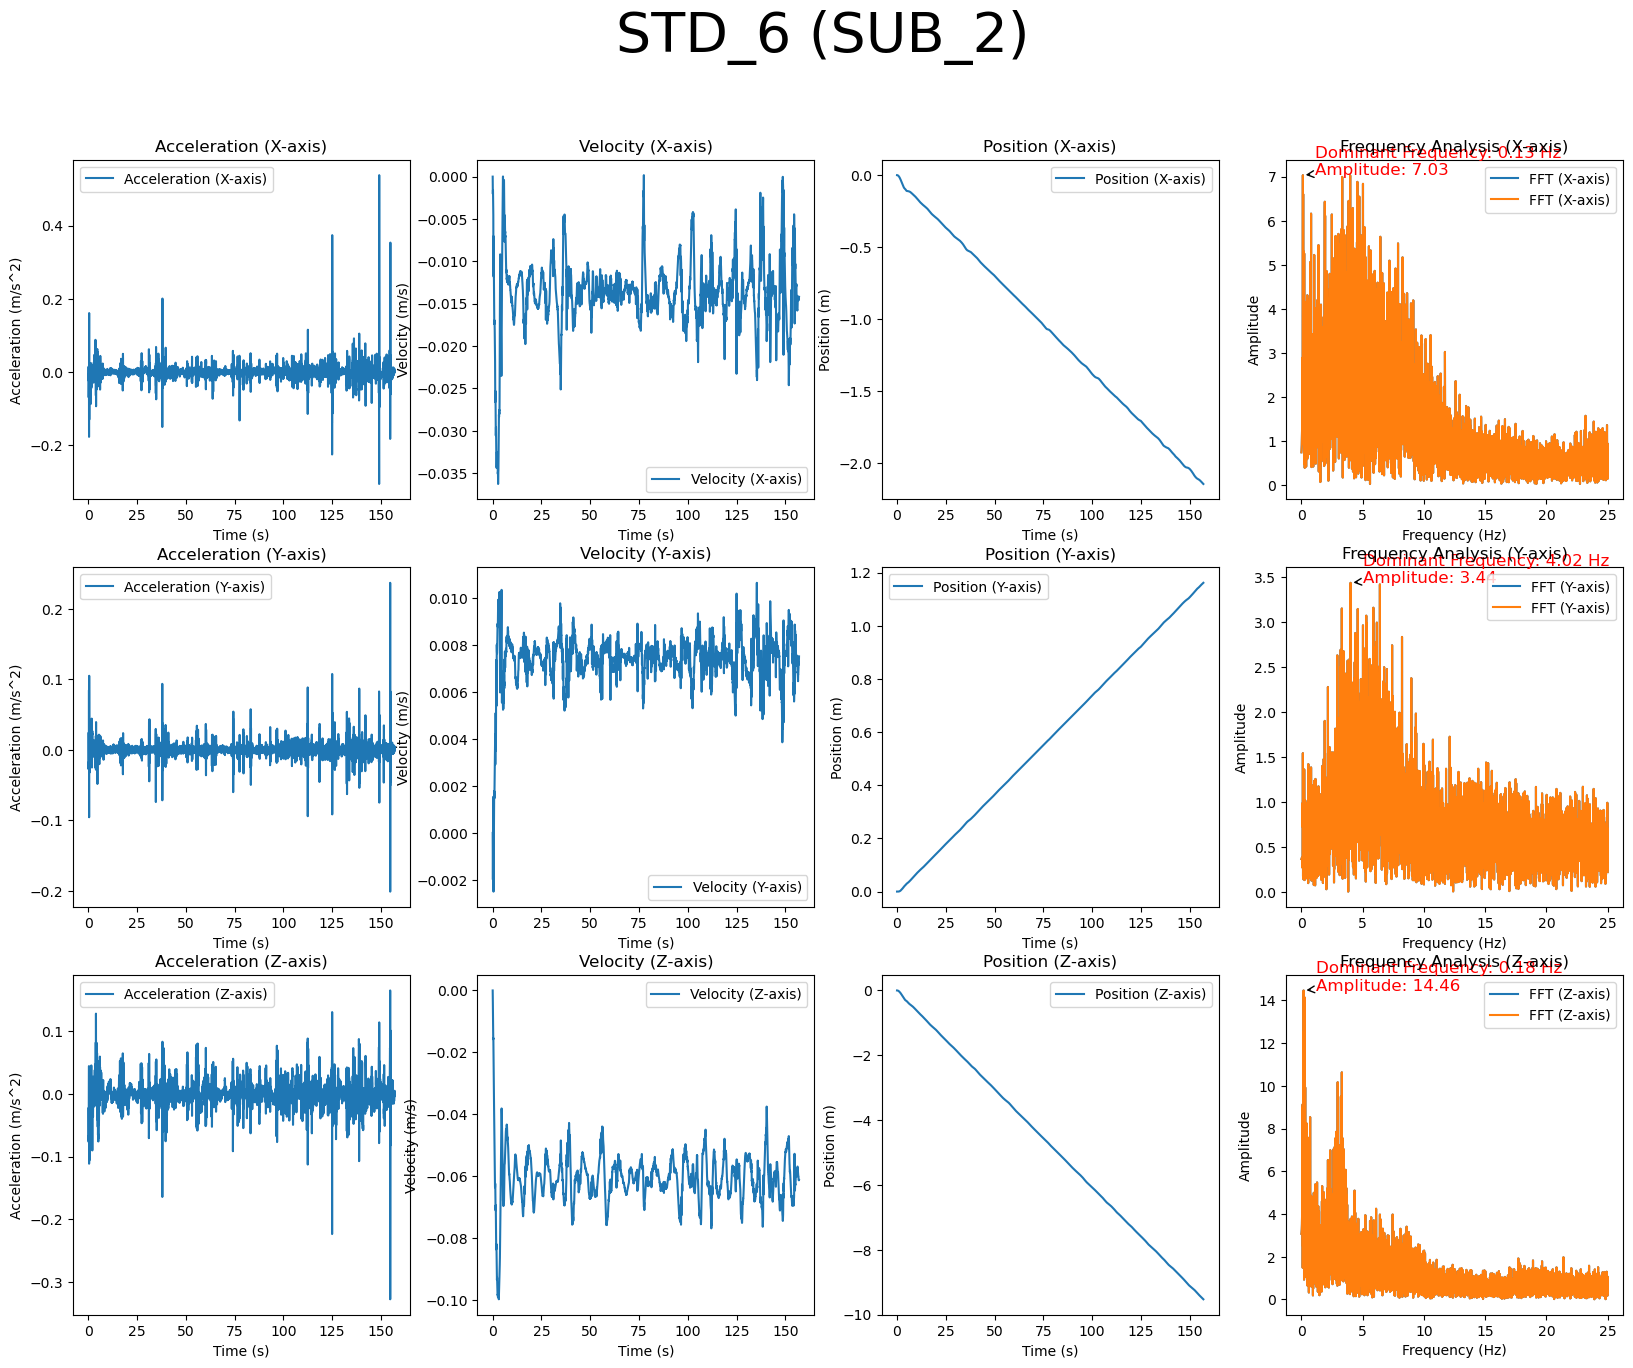

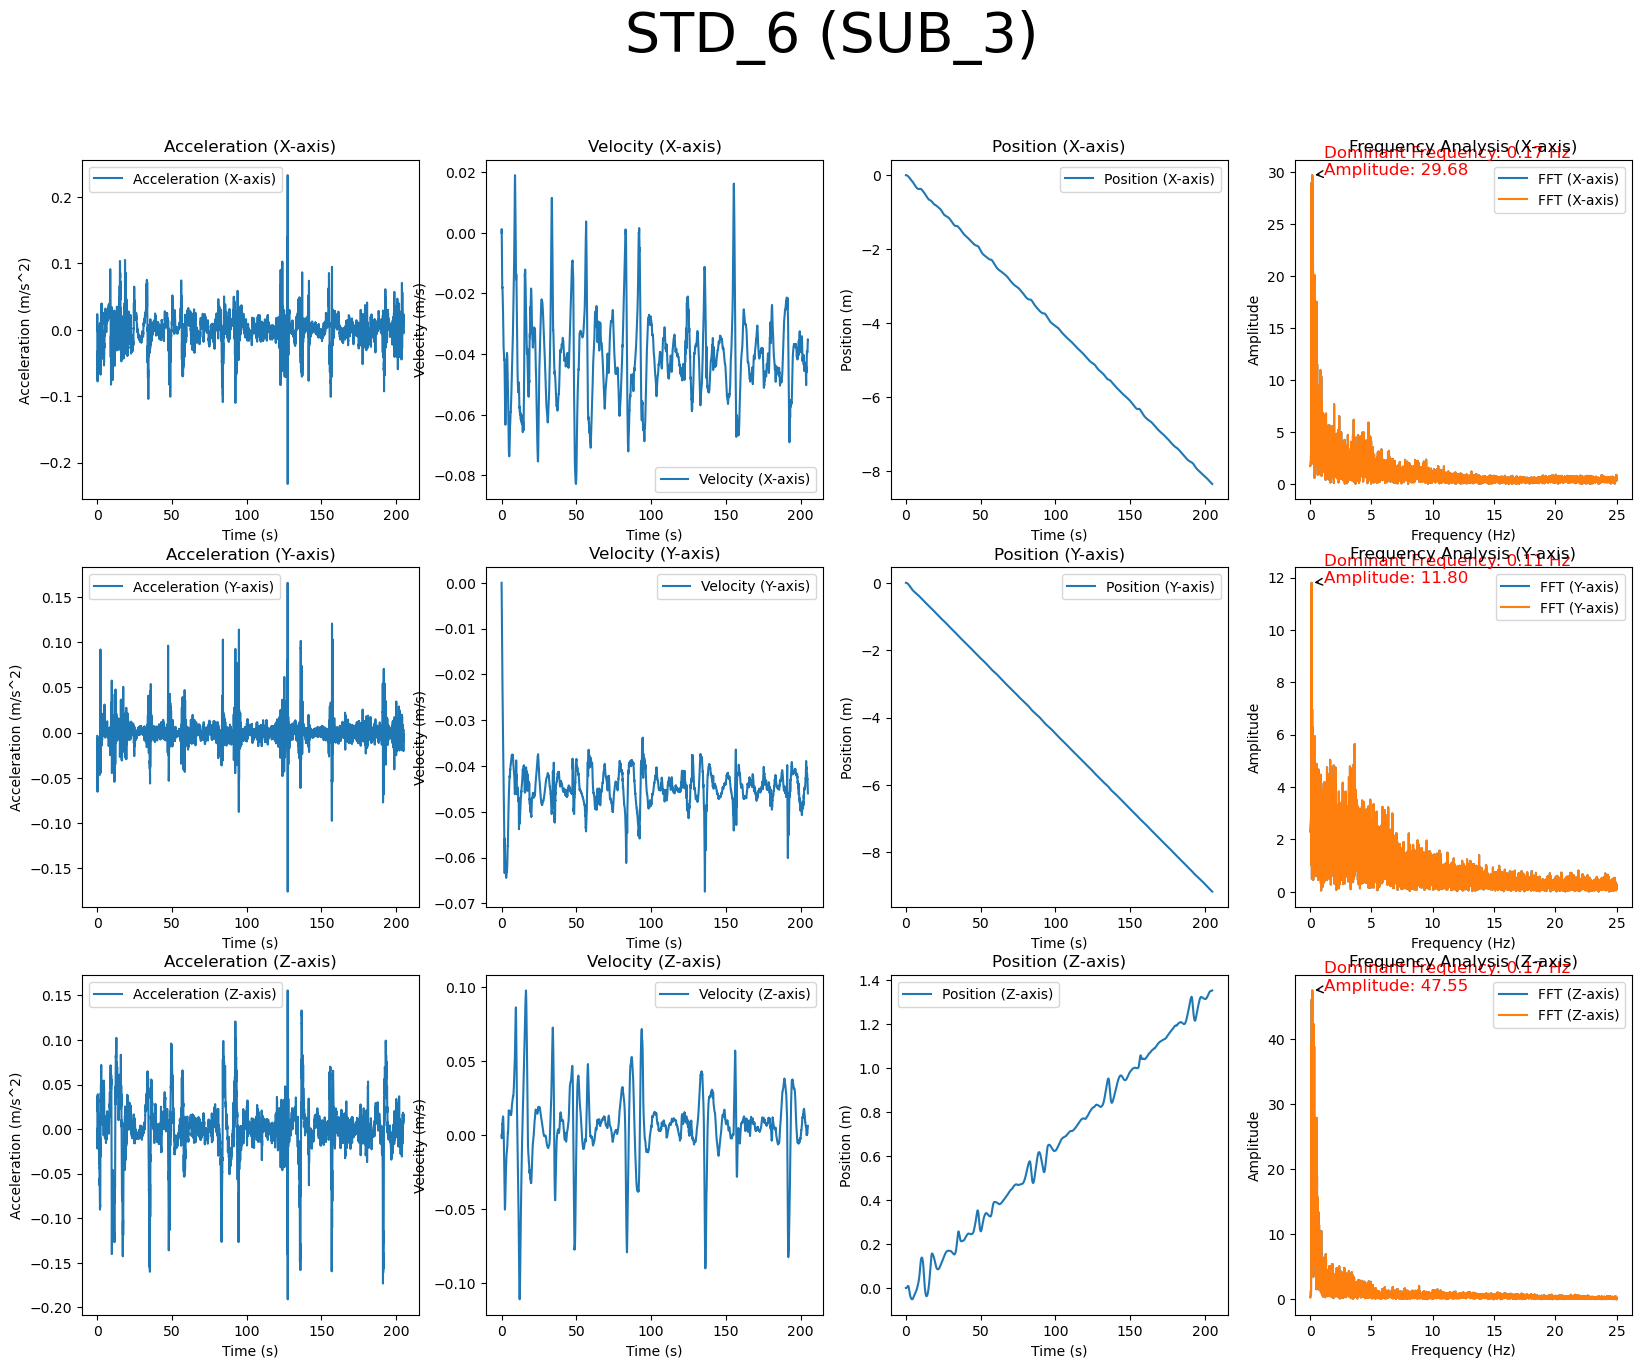

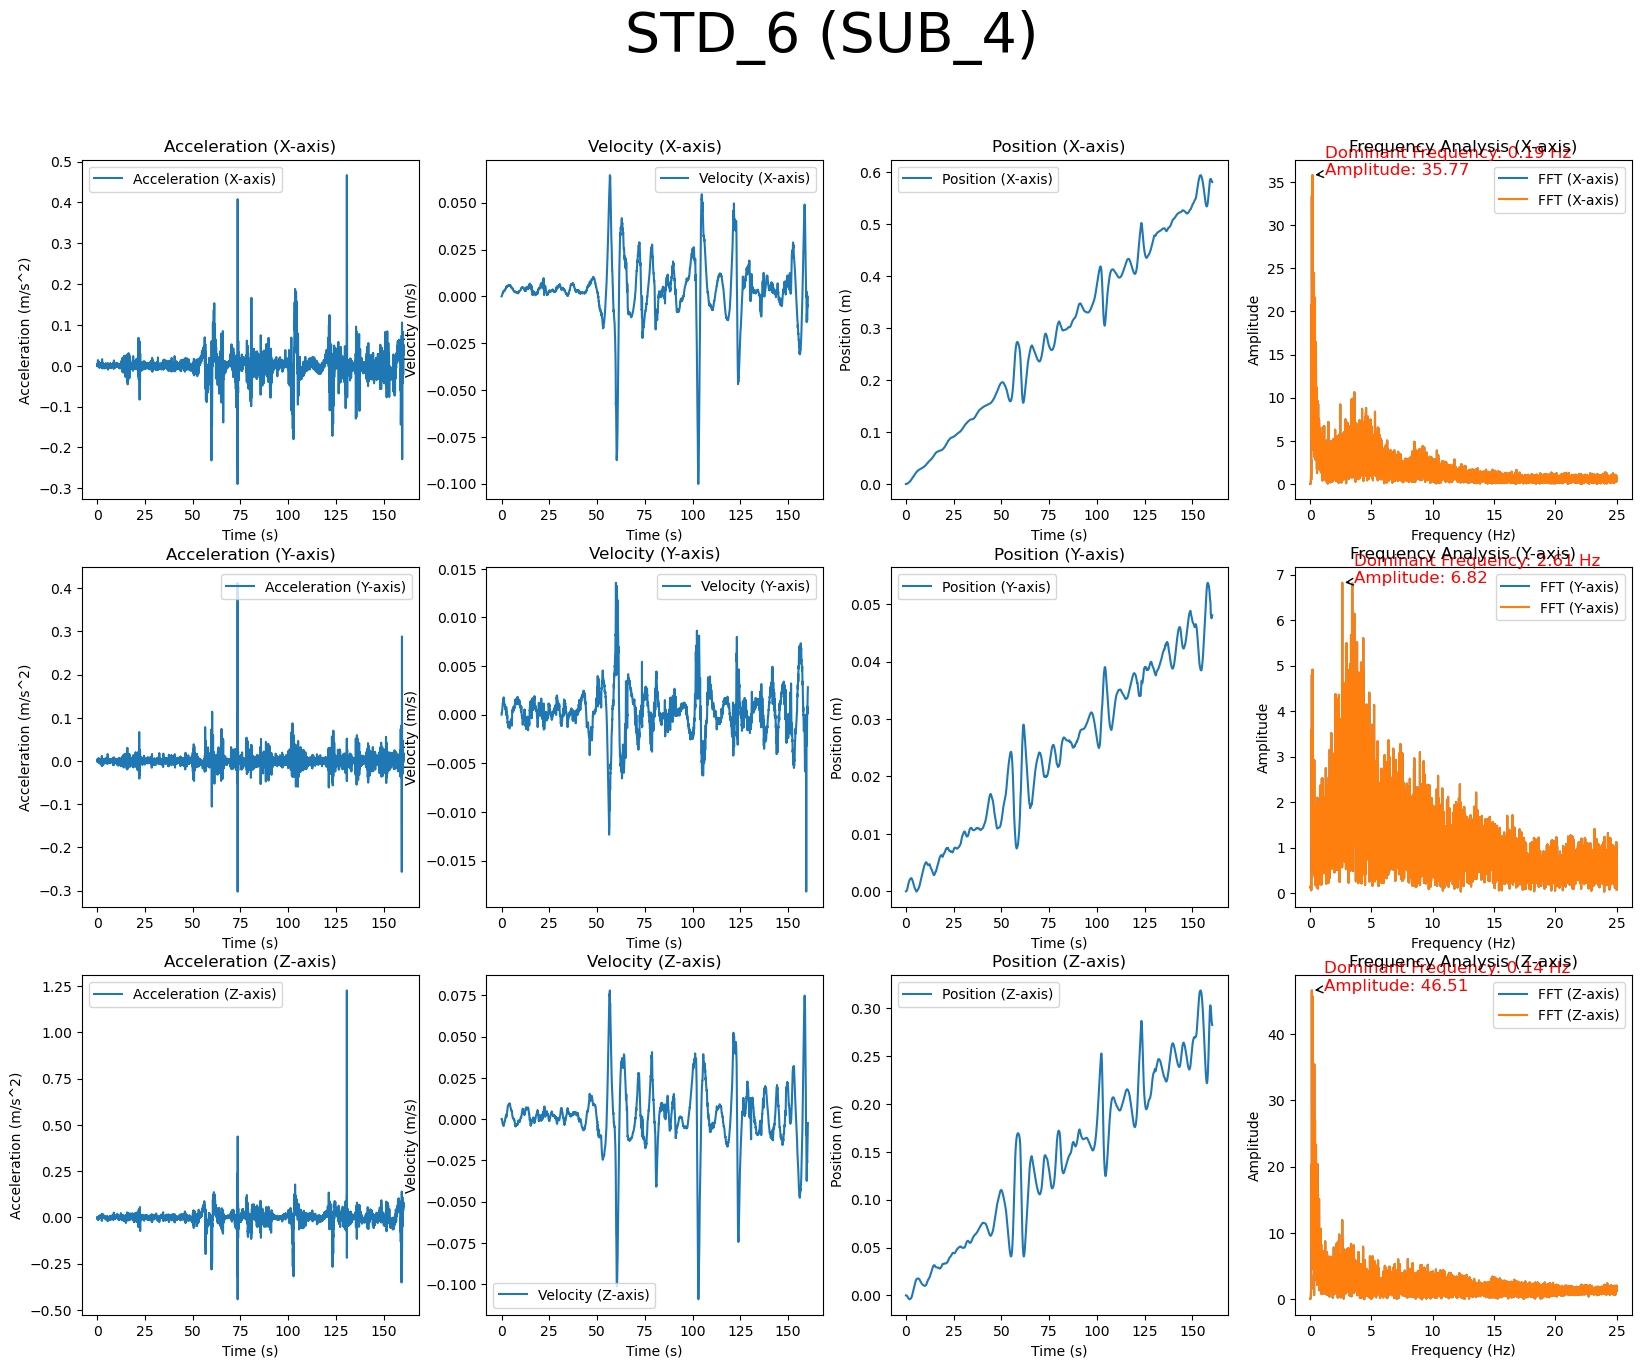

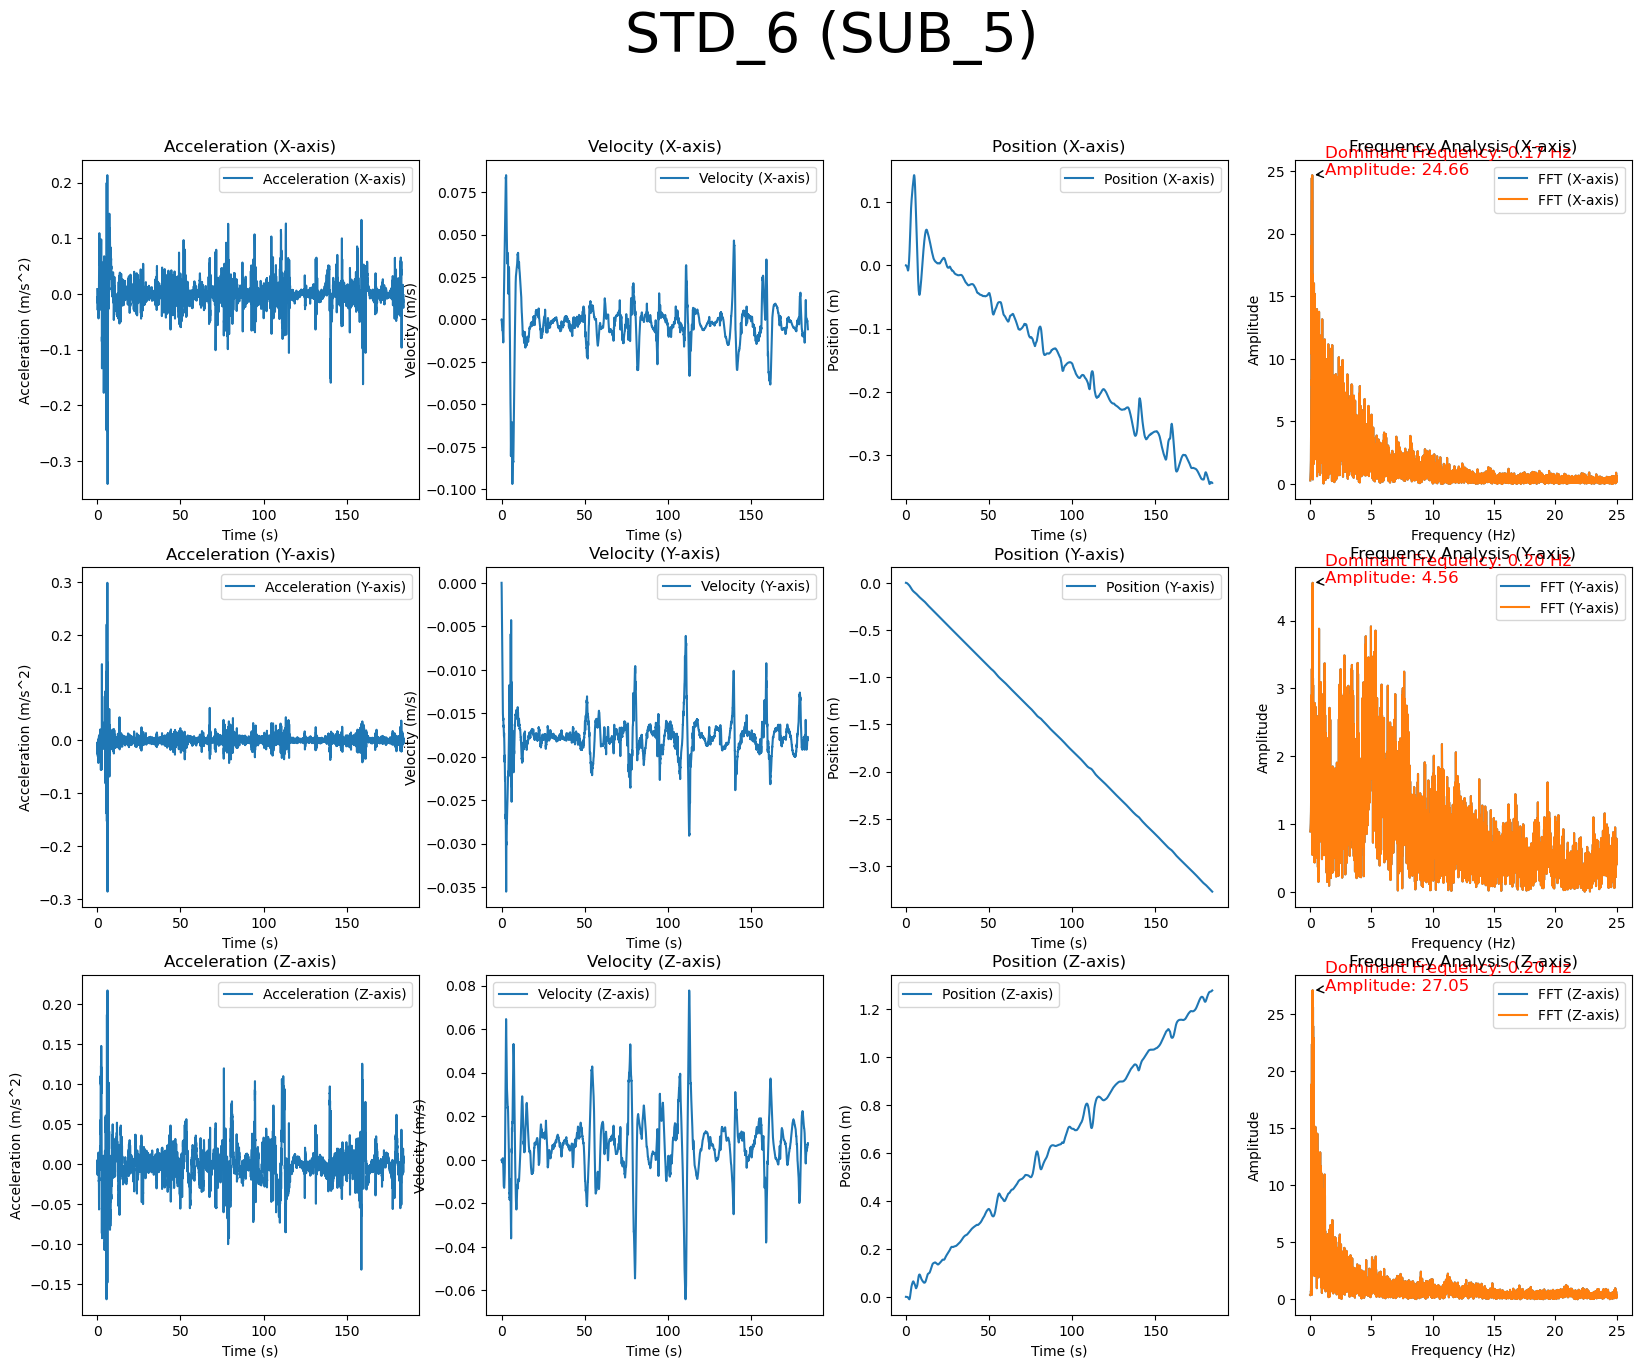

In [77]:
#plot_movement_grav('dws_1/sub_7.csv')
plot_movement_grav_HF_anno('std_6/sub_1.csv')
plot_movement_grav_HF_anno('std_6/sub_2.csv')
plot_movement_grav_HF_anno('std_6/sub_3.csv')
plot_movement_grav_HF_anno('std_6/sub_4.csv')
plot_movement_grav_HF_anno('std_6/sub_5.csv')
#plot_movement_grav('wlk_15/sub_7.csv')
#plot_movement_grav('std_6/sub_7.csv')

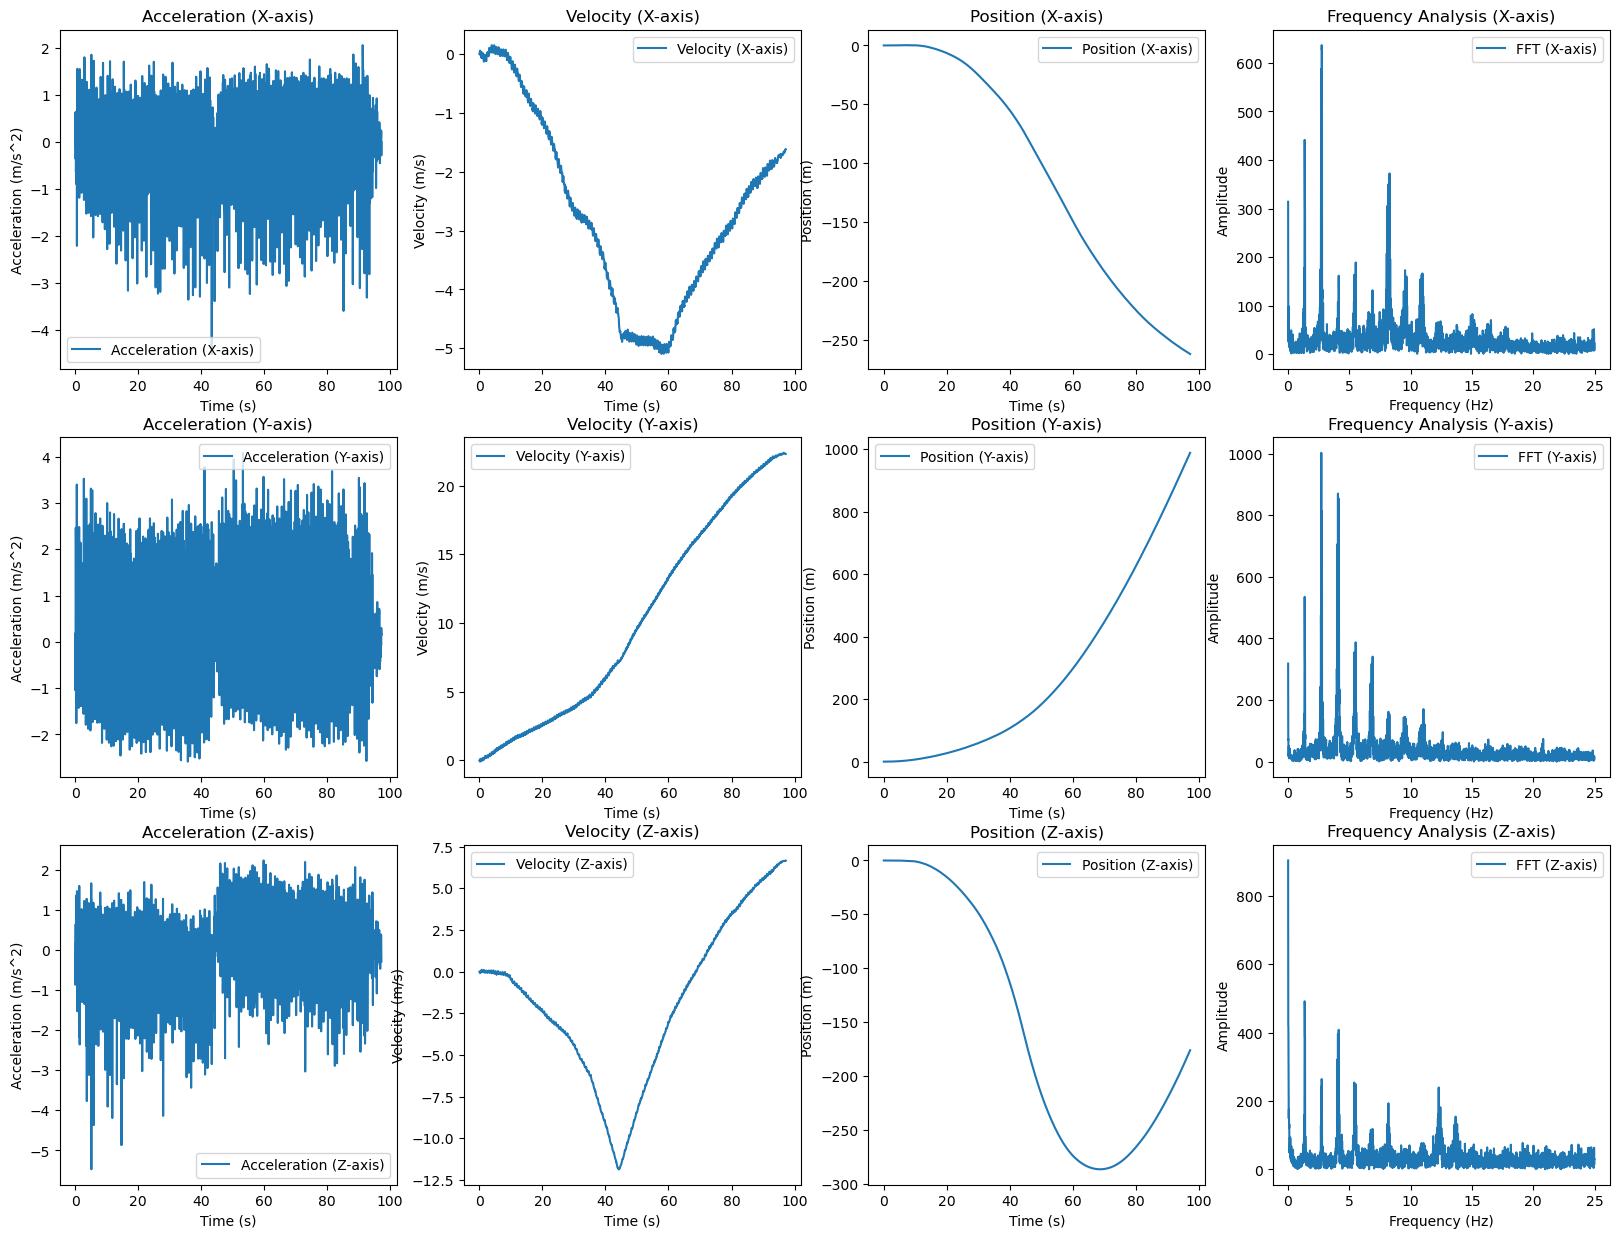

In [41]:
plot_movement('jog_9/sub_1.csv')